In [1]:
import numpy as np 
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import imageio
import datetime
from linear_sca import *

In [4]:
X_init = np.load('/Users/ariellerosinski/My Drive/Cambridge/Project/datasets/churchland.npy') 
D=3

In [5]:
X, _ = pre_processing(X_init, center=False)
X = jnp.array(X)
K, N, T = X.shape
A = jnp.swapaxes(pre_processing(X_init)[0], 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                        #(N, K*T)

In [6]:
def K_X_Y_diagonal(X, Y, sigma_sqrd):
    """For two spatial patterns X and Y, the kernel k(x_i,y_i) is equal to sum_i sigma_i^2 x_i y_i"""
    return jnp.dot(X.T * sigma_sqrd, Y) 

def K_X_Y_identity(X, Y):
    return jnp.dot(X.T, Y) 

In [7]:
K_A_X = K_X_Y_identity(A, X)                                    #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)
K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [8]:
def single_pair_loss(alpha_H, K_A_X, id_1, id_2, operator = 'minus'):
    K_A_X_i = K_A_X[:,id_1,:]
    K_X_A_i = K_A_X[:,id_2,:].T
    
    Q = alpha_H.T @ K_A_X_i @ K_X_A_i @ alpha_H                         #(KT,D).T @ (KT,T) and (T,KT) @ (KT,D) --> (D,T) @ (T,D) --> (D,D)
    QQ_product = jnp.einsum('ij,lm->im', Q, Q)

    if operator == 'minus':
        return jnp.trace(Q)**2 - jnp.trace(QQ_product)
    
    elif operator == 'plus':
        return jnp.trace(Q)**2 + jnp.trace(QQ_product)
 

def loss(alpha_tilde, P, S, K_A_X, X, key, D=3, normalized = False):  
    K, N, T = X.shape
    
    alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
    alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * alpha_tilde_QR


    alpha_reshaped = alpha.reshape(K,T,D)                           #(K, T, D)
    mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)        #(1, T, D)
    alpha_H = (alpha_reshaped - mean).reshape(K*T,D)                #(K*T,D)

    num_pairs = 100  
    indices = random.randint(key, shape=(num_pairs*2,), minval=0, maxval=N)
    index_pairs = indices.reshape((num_pairs, 2))

    batched_loss = vmap(single_pair_loss, in_axes=(None, None, 0, 0))(alpha_H, K_A_X, index_pairs[:, 0], index_pairs[:, 1]) #(num_pairs)

    if normalized == False:
        S = (2 / (num_pairs**2) ) * jnp.sum(batched_loss)
        return -S
    else: 
        batched_normalizer = vmap(single_pair_loss, in_axes=(None, None, 0, 0, None))(alpha_H, K_A_X, index_pairs[:, 0], index_pairs[:, 1], 'plus')
        return jnp.sum(batched_loss) / jnp.sum(batched_normalizer)

def update(alpha_tilde, P, S, K_A_X, X, optimizer, opt_state, key):
    grad_loss = grad(loss)(alpha_tilde, P, S, K_A_X, X, key)
  
    updates, opt_state_updated = optimizer.update(grad_loss, opt_state, alpha_tilde)
    alpha_tilde_updated = optax.apply_updates(alpha_tilde, updates)
    return alpha_tilde_updated, opt_state_updated

def optimize_params(P, S, K_A_X, X, iterations=100, learning_rate=0.01, D=3, seed=42):
    K, N, T = X.shape
    key = random.PRNGKey(seed)
    
    alpha_tilde = random.normal(key, (K*T, D))
    
    keys = random.split(key, num=iterations)

    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(alpha_tilde)

    ls_loss = []
    ls_S_ratio = []
    
    for i in range(iterations):
        alpha_tilde, opt_state = update(alpha_tilde, P, S, K_A_X, X, optimizer, opt_state, keys[i])        

        loss_ = loss(alpha_tilde, P, S, K_A_X, X, keys[i])
        S_ratio = loss(alpha_tilde, P, S, K_A_X, X, keys[i], normalized = True)

        ls_loss.append(loss_)
        ls_S_ratio.append(S_ratio)
        
        if i % 10 == 0:
            print(f"Iteration {i}, S: {-loss_}, S_ratio: {S_ratio}")

    return alpha_tilde, ls_loss

optimized_alpha_tilde, ls_loss = optimize_params(P, S, K_A_X, X)

# now = datetime.datetime.now()
# date_time_str = now.strftime('%d%m%Y_%H%M%S')
# file_name = 'outputs/kernel_SCA/optimized_a_' + date_time_str
# np.save(file_name, optimized_alpha_tilde)

Iteration 0, S: 7775849984.0, S_ratio: 0.5900689363479614
Iteration 10, S: 5445866487808.0, S_ratio: 0.49896568059921265
Iteration 20, S: 111267922575360.0, S_ratio: 0.5436496138572693
Iteration 30, S: 779890496372736.0, S_ratio: 0.6212708353996277
Iteration 40, S: 3317558098788352.0, S_ratio: 0.7177599668502808
Iteration 50, S: 9010572951552000.0, S_ratio: 0.8184276223182678
Iteration 60, S: -3.3818662683017216e+16, S_ratio: -0.48432400822639465
Iteration 70, S: -1.9390707894583296e+16, S_ratio: -0.4580595791339874
Iteration 80, S: -8711616921075712.0, S_ratio: -0.40811997652053833
Iteration 90, S: -3515158001352704.0, S_ratio: -0.33596086502075195


In [26]:
np.save('optimized_alpha_0.001_100', optimized_alpha_tilde)

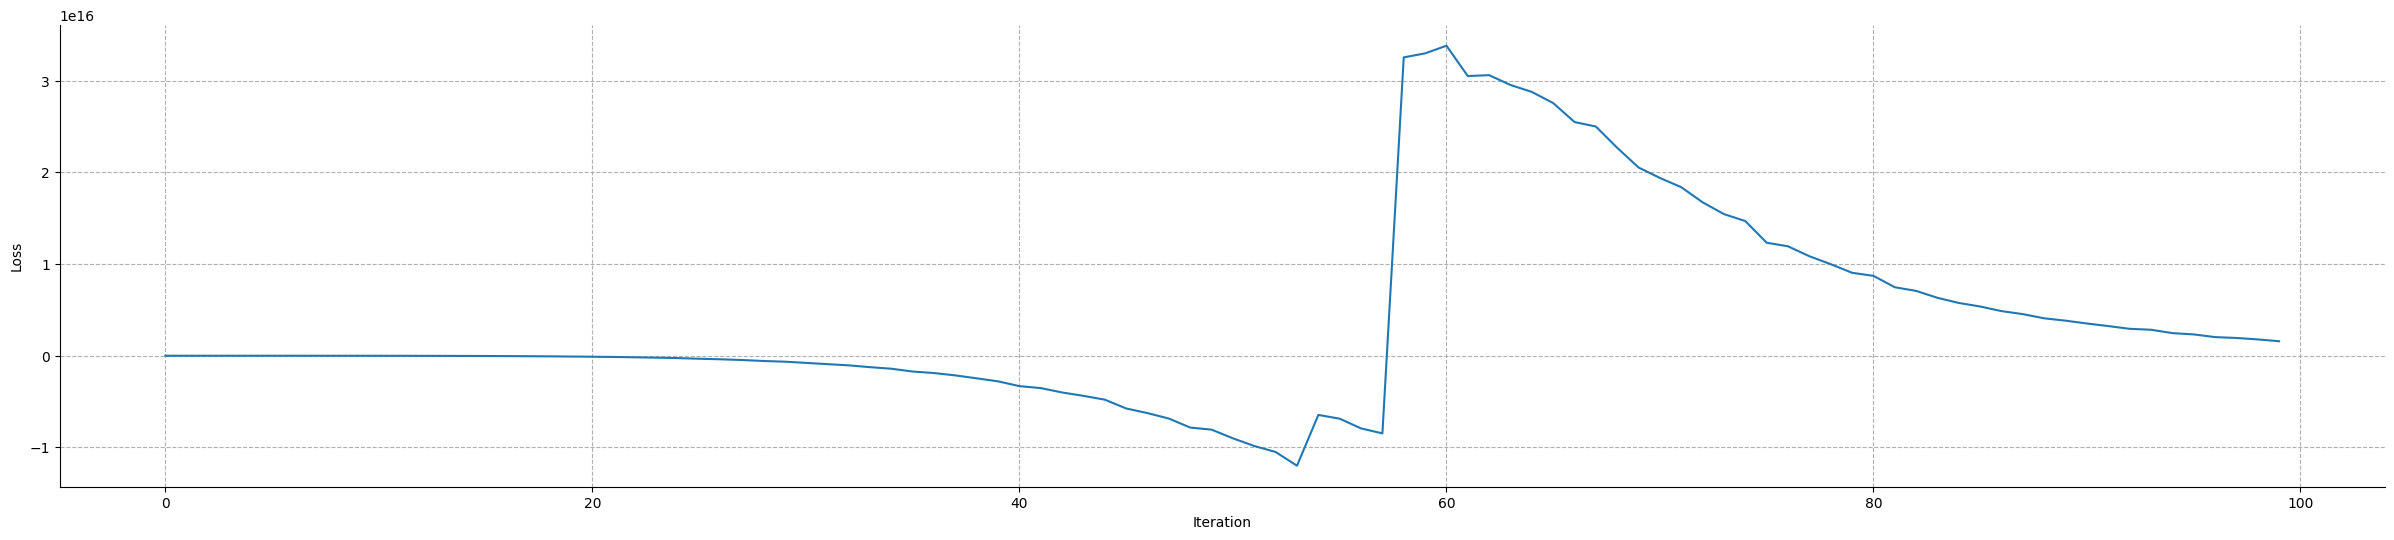

In [9]:
plt.figure(figsize=(30, 6))
plt.plot(ls_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.grid(True, which="both", ls="--") 
plt.gca().spines[['right', 'top']].set_visible(False)


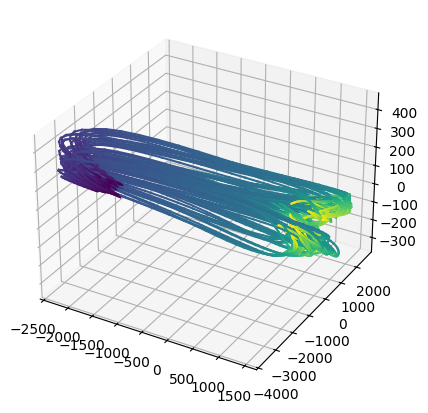

In [10]:
optimized_alpha_tilde_QR, _ = jnp.linalg.qr(optimized_alpha_tilde) 
optimized_alpha = jnp.dot(P , 1/jnp.sqrt(S))[:,None] * optimized_alpha_tilde_QR
#optimized_alpha = jnp.dot(P * 1/jnp.sqrt(S), optimized_alpha_tilde_QR)

optimized_alpha_reshaped = optimized_alpha.reshape(K,T,D)                                 #(K, T, D)
mean = jnp.mean(optimized_alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, D)
optimized_alpha_H = (optimized_alpha_reshaped - mean).reshape(K*T,D)                      #(K*T,D)
projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X)                          #(K*T,D) @ (K*T, K, T) --> (K, D, T)


fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap('viridis')

num_time_points = projection.shape[-1]
indices_to_plot = np.arange(0,projection.shape[0],1)

for i in indices_to_plot:
    x = projection[i, 0, :]  
    y = projection[i, 1, :] 
    z = projection[i, 2, :]  
    
    for t in range(num_time_points - 1):
        ax.plot(x[t:t+2], y[t:t+2], z[t:t+2], color=cmap(t / (num_time_points - 1)))

# fig_name = 'outputs/kernel_SCA/' + date_time_str + '_proj.png'
# fig.savefig(fig_name)

In [25]:
def make_frame(angle):
    ax.view_init(30, angle)
    fig.canvas.draw() 
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    return image

angles = range(0, 360, 2) 
frames = [make_frame(angle) for angle in angles]

gif_path =  'outputs/kernel_SCA/trajectories_rotation.gif' #+ date_time_str + "_trajectories_rotation_test.gif"
imageio.mimsave(gif_path, frames, fps=20)

gif_path

/var/folders/rc/1hy0j2s15dn18v_vb39s2dph0000gn/T/ipykernel_51860/3329625286.py:4: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')


'outputs/kernel_SCA/trajectories_rotation.gif'

ENDS HERE